In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = "/content/drive/My Drive/Med_Seg/Datasets/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))



In [ ]:
related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

In [ ]:
paths_df

,image_path,mask_path
0,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
1,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
2,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
3,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
4,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
...,...,...
705,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
706,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
707,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...
708,/content/drive/My Drive/Med_Seg/Datasets/Lung ...,/content/drive/My Drive/Med_Seg/Datasets/Lung ...


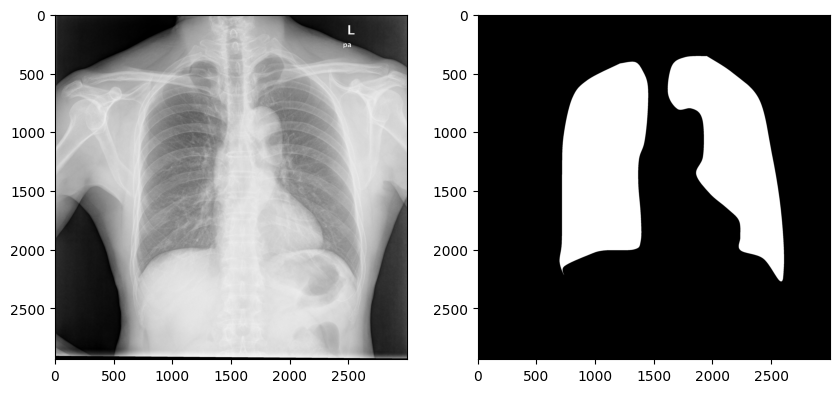

In [ ]:
xray_num = 5
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

In [ ]:
from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)

    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")

100%|██████████| 710/710 [10:52<00:00,  1.09it/s]


In [ ]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

In [ ]:
### U-net
import keras

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *
from tensorflow.keras import backend as K

# def dice_coef(y_true, y_pred):
#     y_true_f = keras.flatten(y_true)
#     y_pred_f = keras.flatten(y_pred)
#     intersection = keras.sum(y_true_f * y_pred_f)
#     return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
from keras.metrics import Precision, Recall,F1Score
EPOCHS = 10
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy", \
                  metrics=[dice_coef,Precision(),Recall(),'binary_accuracy', MeanIoU(num_classes=2, name="IoU")])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 256, 256, 32)   │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 128, 128, 32)   │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 64, 64, 64)     │              0 │ conv2d_60[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 32, 32, 128)    │              0 │ conv2d_62[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 16, 16, 256)    │              0 │ conv2d_64[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_12       │ (None, 32, 32, 256)    │        524,544 │ conv2d_66[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12       

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(x = img_train,
                    y = mask_train,
                    validation_data = (img_test, mask_test),
                    epochs = 30,
                    batch_size = 16,
                   callbacks = [earlystopping])

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - IoU: 0.4851 - binary_accuracy: 0.9829 - dice_coef: 0.9511 - loss: 0.0404 - precision_3: 0.9723 - recall_3: 0.9620 - val_IoU: 0.4864 - val_binary_accuracy: 0.9776 - val_dice_coef: 0.9448 - val_loss: 0.0624 - val_precision_3: 0.9654 - val_recall_3: 0.9494
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - IoU: 0.5108 - binary_accuracy: 0.9841 - dice_coef: 0.9555 - loss: 0.0371 - precision_3: 0.9749 - recall_3: 0.9637 - val_IoU: 0.5611 - val_binary_accuracy: 0.9772 - val_dice_coef: 0.9451 - val_loss: 0.0654 - val_precision_3: 0.9552 - val_recall_3: 0.9595
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - IoU: 0.5485 - binary_accuracy: 0.9847 - dice_coef: 0.9588 - loss: 0.0356 - precision_3: 0.9745 - recall_3: 0.9685 - val_IoU: 0.4906 - val_binary_accuracy: 0.9765 - val_dice_coef: 0.9411 - val_loss: 0.0635 - val_precision_3: 0.9611 - val_recall_3: 0.9495
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - IoU: 0.5186 - bina

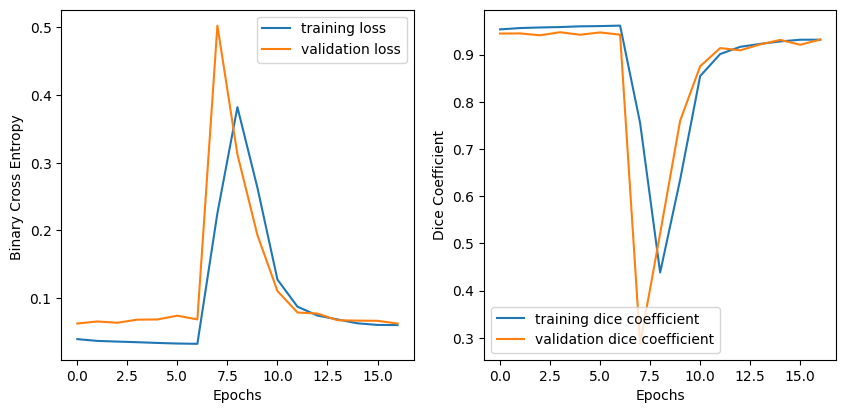

In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy ")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")

get_metrics(history = history)

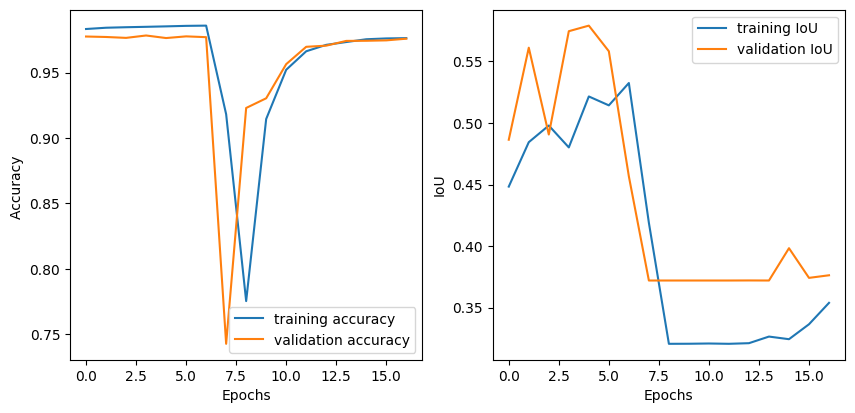

In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["binary_accuracy"], label = "training accuracy")
    plt.plot(history.history["val_binary_accuracy"], label = "validation accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy ")

    plt.subplot(2,2,2)
    plt.plot(history.history["IoU"], label = "training IoU")
    plt.plot(history.history["val_IoU"], label = "validation IoU")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
get_metrics(history = history)

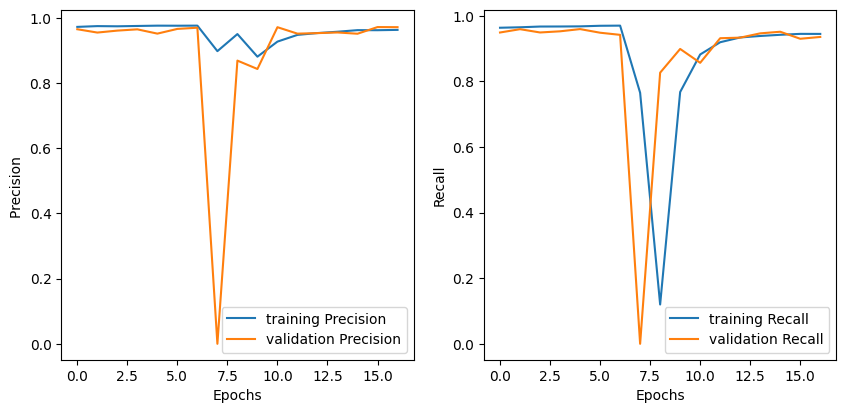

In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["precision_3"], label = "training Precision")
    plt.plot(history.history["val_precision_3"], label = "validation Precision")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Precision ")

    plt.subplot(2,2,2)
    plt.plot(history.history["recall_3"], label = "training Recall")
    plt.plot(history.history["val_recall_3"], label = "validation Recall")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
get_metrics(history = history)

In [ ]:
accuracy = history.history["val_binary_accuracy"]
precision = history.history["val_precision_3"]
recall = history.history["val_recall_3"]
iou = history.history["val_IoU"]
dice_coef = history.history["val_dice_coef"]
print("The Accuracy of the UNET model:",round(accuracy[-1],2))
print("The Precision of the UNET model:",round(precision[-1],2))
print("The Recall of the UNET model:",round(recall[-1],2))
print("The IOU Score of the UNET model:",round(iou[-1],2))
print("The Dice Score of the UNET model:",round(dice_coef[-1],2))


The Accuracy of the UNET model: 0.98
The Precision of the UNET model: 0.97
The Recall of the UNET model: 0.94
The IOU Score of the UNET model: 0.38
The Dice Score of the UNET model: 0.93


In [ ]:
def test_on_images(model, img_array, mask_array, img_side_size=128):
    num_images = img_array.shape[0]
    predictions = []
    dice_scores = []

    for img_num in range(num_images):
        pred = model.predict(img_array[img_num].reshape(1, img_side_size, img_side_size, 1))
        pred[pred > 0.5] = 1.0
        pred[pred < 0.5] = 0.0
        predictions.append(pred)

        fig = plt.figure(figsize=(15, 10))
        plt.subplot(1, 4, 1)
        plt.imshow(pred.reshape(img_side_size, img_side_size), cmap="Blues")
        plt.title("Prediction")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(mask_array[img_num].reshape(img_side_size, img_side_size), cmap="Blues")
        plt.title("Original Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.show()

    return predictions

# Assuming img_test and mask_test are the image and mask arrays
predictions = test_on_images(model, img_array=img_test, mask_array=mask_test, img_side_size=256)


Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

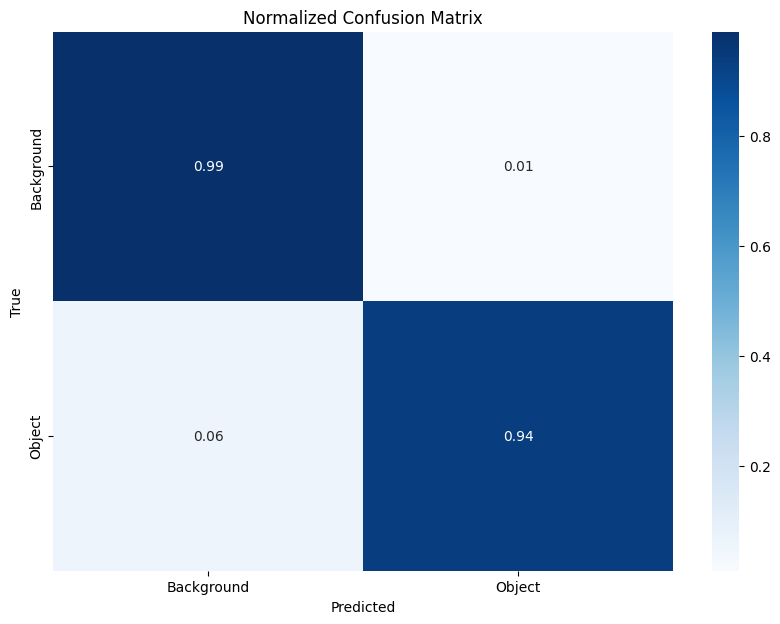

Confusion Matrix (Raw):
 [[6850692   67921]
 [ 149749 2237750]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test_on_image(model, img_array, img_num, img_side_size=256):
    pred = model.predict(img_array[img_num].reshape(1, img_side_size, img_side_size, 1))
    pred[pred > 0.5] = 1.0
    pred[pred <= 0.5] = 0.0
    return pred

def get_predictions_and_true_masks(model, img_test, mask_test, img_side_size=256):
    y_true = []
    y_pred = []
    for i in range(len(img_test)):
        prediction = test_on_image(model, img_array=img_test, img_num=i, img_side_size=img_side_size)
        y_true.append(mask_test[i].flatten())
        y_pred.append(prediction.flatten())
    return np.concatenate(y_true), np.concatenate(y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, normalize=False):
    plt.figure(figsize=(10, 7))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix"

    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Get the true and predicted values
y_true, y_pred = get_predictions_and_true_masks(model, img_test, mask_test)

# Ensure the predictions are binary
y_pred = np.round(y_pred).astype(int)
y_true = np.round(y_true).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names=["Background", "Object"], normalize=True)
# plot_confusion_matrix(cm, class_names=["Background", "Object"], normalize=False)

print("Confusion Matrix (Raw):\n", cm)
# print("Confusion Matrix (Normalized):\n", cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

In [ ]:
dice_coefs = list()
# for i in tqdm(range(len(img_test))):
#     prediction = test_on_image(model, img_array = img_test, img_num = i, img_side_size = 256)
#     dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction)
#     dice_coefs.append(dice)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

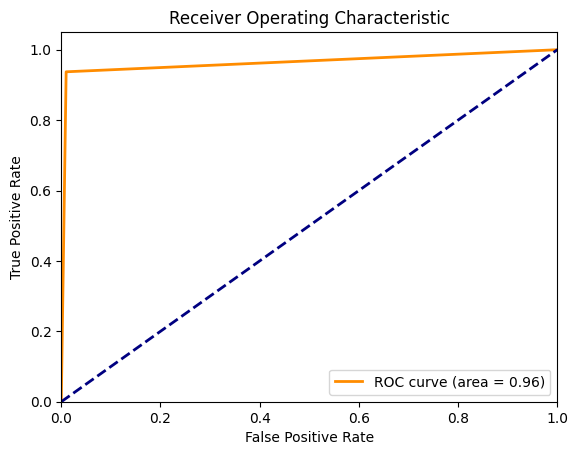

ROC AUC: 0.9637303691967537


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming the function to get true and predicted masks is defined as:
def get_predictions_and_true_masks(model, img_test, mask_test, img_side_size=256):
    y_true = []
    y_pred = []
    for i in range(len(img_test)):
        prediction = test_on_image(model, img_array=img_test, img_num=i, img_side_size=img_side_size)
        y_true.append(mask_test[i].flatten())
        y_pred.append(prediction.flatten())
    return np.concatenate(y_true), np.concatenate(y_pred)

# Get the true and predicted values
y_true, y_pred = get_predictions_and_true_masks(model, img_test, mask_test)

# Ensure the predictions and true values are binary and flattened
y_true = np.round(y_true).astype(int).ravel()
y_pred = y_pred.ravel()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc}")